Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1: Train Acc=0.4000, Val Acc=0.5333
Epoch 2: Train Acc=0.6268, Val Acc=0.5833
Epoch 3: Train Acc=0.7018, Val Acc=0.7958
Epoch 4: Train Acc=0.7839, Val Acc=0.7208
Epoch 5: Train Acc=0.8232, Val Acc=0.8167
Epoch 6: Train Acc=0.8768, Val Acc=0.8083
Epoch 7: Train Acc=0.8964, Val Acc=0.8458
Epoch 8: Train Acc=0.8911, Val Acc=0.8417
Epoch 9: Train Acc=0.9018, Val Acc=0.8333
Epoch 10: Train Acc=0.9268, Val Acc=0.8000
Epoch 11: Train Acc=0.9500, Val Acc=0.8625
Epoch 12: Train Acc=0.9536, Val Acc=0.8583
Epoch 13: Train Acc=0.9411, Val Acc=0.8458
Epoch 14: Train Acc=0.9679, Val Acc=0.8417
Epoch 15: Train Acc=0.9696, Val Acc=0.8375

Classification Report:
              precision    recall  f1-score   support

       apple       0.94      0.89      0.92        19
      banana       0.94      0.89      0.91        18
       mixed       0.50      0.80      0.62         5
      orange       0.88      0.83      0.86        18

  

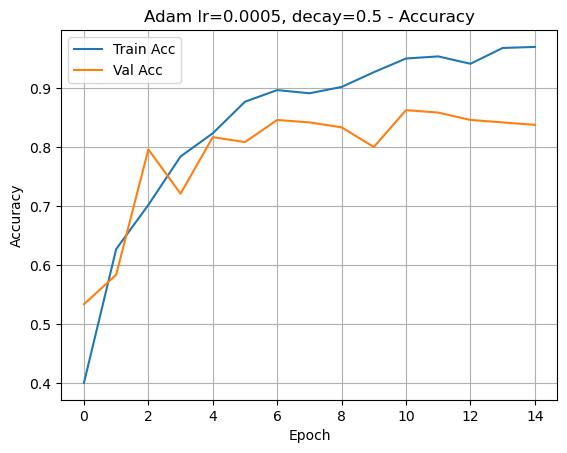

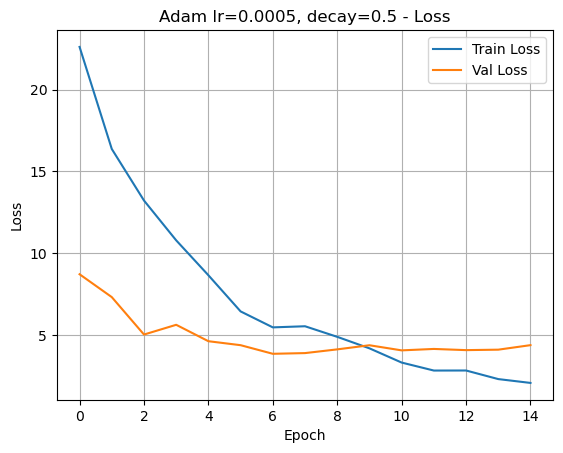

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
import numpy as np
import random
import matplotlib.pyplot as plt

# Set random seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

# Model definition
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 4)
        )
    def forward(self, x):
        return self.model(x)

# Training function
def train_single_model(train_path, test_path, optimizer_name='Adam', lr=0.001, lr_decay=0.9, batch_size=32, epochs=15, seed=42):
    set_seed(seed)

    # Transforms
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Data loading
    train_data = ImageFolder(train_path, transform=transform)
    test_data = ImageFolder(test_path, transform=transform)

    train_size = int(0.7 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    print("Classes:", train_data.classes)
    print("Using device:", device)

    model = FruitCNN().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=lr_decay)

    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_acc.append(correct / total)
        train_loss.append(running_loss)

        # Validation
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss_batch = criterion(val_outputs, val_labels)
                val_running_loss += val_loss_batch.item()
                _, val_preds = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_preds == val_labels).sum().item()
        val_acc.append(val_correct / val_total)
        val_loss.append(val_running_loss)
        scheduler.step()

        print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")

    # Test Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=train_data.classes))

    # Plotting
    plt.figure()
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title(f'{optimizer_name} lr={lr}, decay={lr_decay} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'{optimizer_name} lr={lr}, decay={lr_decay} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# ✅ Run with single config
train_single_model(
    train_path="../train",
    test_path="../test",
    optimizer_name='Adam',
    lr=0.0005,
    lr_decay=0.5,
    batch_size=32,
    epochs=15,
    seed=42
)